## Semantic Segmentation using U-Net on Aerial Image Dataset

**Author: Abhishek Dey**

### Import Libraries

In [25]:
import os
import cv2
import glob
import json
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp


### Utils

In [22]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

### Dataset Class

In [32]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
import cv2

# ---------------- Utils ----------------
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


# ---------------- Dataset ----------------
class AerialDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
        self.transform = transform

        # Correct RGB colors for your dataset
        self.classes = [
            ("Water", "#E2A929"),
            ("Land (unpaved area)", "#8429F6"),
            ("Road", "#6EC1E4"),
            ("Building", "#3C1098"),
            ("Vegetation", "#FEDD3A"),
            ("Unlabeled", "#9B9B9B")
        ]

        self.idx_to_name = {i: name for i, (name, _) in enumerate(self.classes)}
        self.class_colors = [hex_to_rgb(c[1]) for c in self.classes]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = os.path.basename(img_path)
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Load
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))

        # Vectorized nearest-color mapping
        h, w, _ = mask.shape
        mask_flat = mask.reshape(-1, 3)
        colors = np.array(self.class_colors)  # [num_classes, 3]

        # Compute squared distances
        dists = np.sum((mask_flat[:, None, :] - colors[None, :, :]) ** 2, axis=2)
        class_ids = np.argmin(dists, axis=1)
        class_mask = class_ids.reshape(h, w)

        # Apply transforms (images: bilinear, masks: nearest)
        if self.transform:
            augmented = self.transform(image=img, mask=class_mask)
            img, class_mask = augmented["image"], augmented["mask"]

        # Convert to torch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        class_mask = torch.from_numpy(class_mask).long()

        return img, class_mask


# ---------------- Transforms ----------------
train_transform = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
])

val_transform = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
    A.Normalize(),
])


### Datasets & Dataloaders

In [34]:

# ----- Dataset & DataLoader -----
root = "./aerial_image_dataset"

train_dataset = AerialDataset(
    os.path.join(root, "train/images"),
    os.path.join(root, "train/masks"),
    transform=train_transform
)

val_dataset = AerialDataset(
    os.path.join(root, "val/images"),
    os.path.join(root, "val/masks"),
    transform=val_transform
)

test_dataset = AerialDataset(
    os.path.join(root, "test/images"),
    os.path.join(root, "test/masks"),
    transform=val_transform
)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# ----- Sanity check -----
images, masks = next(iter(train_loader))
print("Image batch:", images.shape)  # [B,3,H,W]
print("Mask batch:", masks.shape)    # [B,H,W]

Image batch: torch.Size([4, 3, 256, 256])
Mask batch: torch.Size([4, 256, 256])


### Dataset Size

In [35]:
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 57
Val size: 7
Test size: 8


### Visualise sample data

In [36]:
def visualize_random_samples(dataset, num_samples=4):
    """
    Visualize random images and corresponding masks from a dataset.

    Args:
        dataset: AerialDataset (must have .class_colors attribute).
        num_samples (int): Number of random samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)
    class_colors = np.array(dataset.class_colors, dtype=np.uint8)  # Convert list of tuples → array

    plt.figure(figsize=(12, num_samples * 3))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]

        # Convert tensors to numpy
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()

        # Convert image [C,H,W] → [H,W,C]
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        # Normalize image to [0,1] for visualization
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Convert class indices → RGB mask
        color_mask = class_colors[mask]

        # Debug: print unique class IDs in this mask
        print(f"Sample {idx} unique mask values:", np.unique(mask))

        # Plot image
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image.astype(np.float32))
        plt.axis("off")
        plt.title(f"Image {idx}")

        # Plot mask
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(color_mask)
        plt.axis("off")
        plt.title(f"Mask {idx}")

    plt.tight_layout()
    plt.show()


Sample 11 unique mask values: [0 1 2 3 4 5]
Sample 1 unique mask values: [0 1 2 3 4 5]


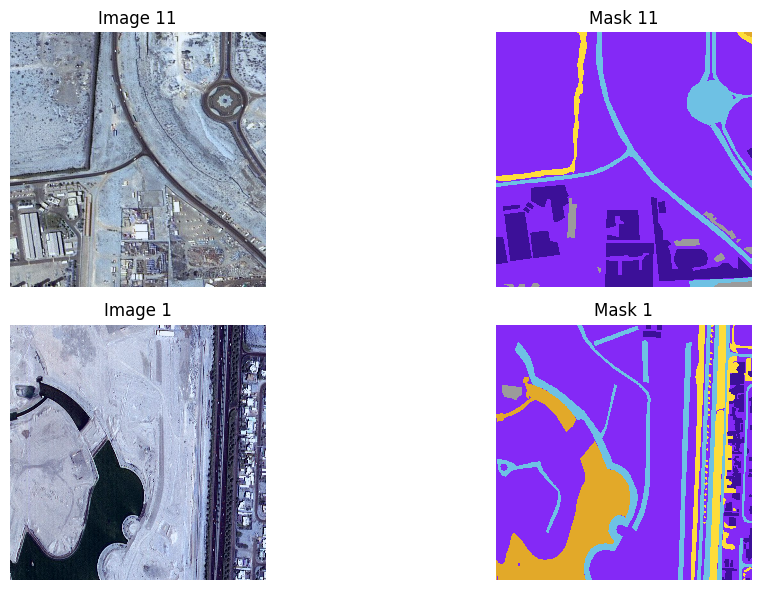

Sample 3 unique mask values: [1 2 3 5]
Sample 4 unique mask values: [0 1 2 3 4]


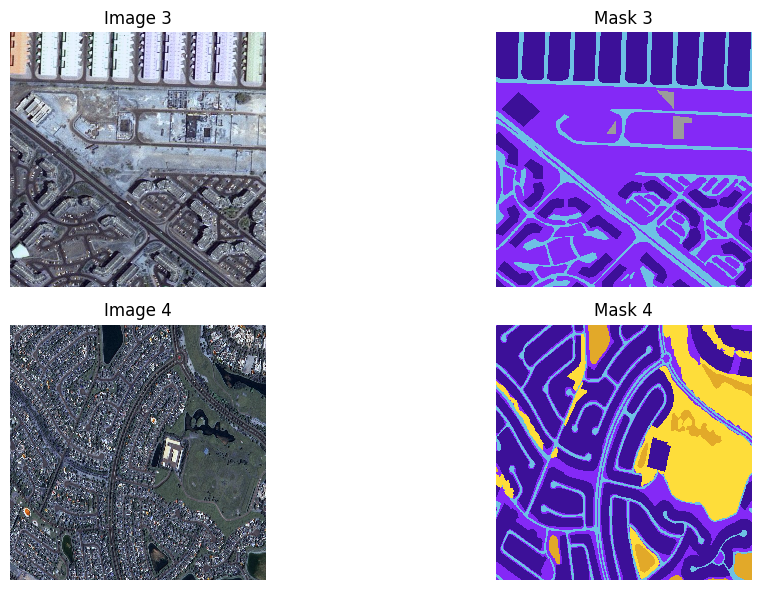

In [37]:
visualize_random_samples(train_dataset, num_samples=2)
visualize_random_samples(val_dataset, num_samples=2)
#visualize_random_samples(test_dataset, num_samples=2)

## Training and validation loops

In [38]:
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    return epoch_loss / len(loader)


def validate_one_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            epoch_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})
    return epoch_loss / len(loader)


### Model Setup

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

num_classes = 6
batch_size = 8
epochs = 100
lr = 1e-3

ENCODER = "resnet18"
ENCODER_WEIGHTS = "imagenet"
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Model
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=num_classes,
    activation=None
).to(device)

# Loss & Optimizer
loss_fn = smp.losses.DiceLoss(mode="multiclass")
optimizer = optim.Adam(model.parameters(), lr=lr)

# --- Save best model ---
best_val_loss = float("inf")
best_model_path = "./best_unet_model.pth"


Using device: cuda


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

### Model Training

In [46]:
train_losses = []
val_losses   = []

for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}] -----------------------------")

    # ---- Train & Validate ----
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss   = validate_one_epoch(model, val_loader, loss_fn, device)

    # ---- Save history ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # ---- Save best model ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved best model at epoch {epoch+1} with val_loss={val_loss:.4f}")

print(f"\nTraining complete. Best model saved to {best_model_path}")



Epoch [1/100] -----------------------------


Train Loss: 0.7092  Val Loss: 0.7549
✅ Saved best model at epoch 1 with val_loss=0.7549

Epoch [2/100] -----------------------------


Train Loss: 0.6096  Val Loss: 0.6618
✅ Saved best model at epoch 2 with val_loss=0.6618

Epoch [3/100] -----------------------------


Train Loss: 0.6006  Val Loss: 0.6620

Epoch [4/100] -----------------------------


Train Loss: 0.5532  Val Loss: 0.5384
✅ Saved best model at epoch 4 with val_loss=0.5384

Epoch [5/100] -----------------------------


Train Loss: 0.5169  Val Loss: 0.5494

Epoch [6/100] -----------------------------


Train Loss: 0.5250  Val Loss: 0.5950

Epoch [7/100] -----------------------------


Train Loss: 0.5015  Val Loss: 0.5336
✅ Saved best model at epoch 7 with val_loss=0.5336

Epoch [8/100] -----------------------------


Train Loss: 0.4663  Val Loss: 0.5363

Epoch [9/100] -----------------------------


Train Loss: 0.4787  Val Loss: 0.4904
✅ Saved best model at epoch 9 with val_loss=0.4904

Epoch [10/100] -----------------------------


Train Loss: 0.4819  Val Loss: 0.5452

Epoch [11/100] -----------------------------


Train Loss: 0.5163  Val Loss: 0.5840

Epoch [12/100] -----------------------------


Train Loss: 0.4438  Val Loss: 0.4654
✅ Saved best model at epoch 12 with val_loss=0.4654

Epoch [13/100] -----------------------------


Train Loss: 0.4625  Val Loss: 0.4787

Epoch [14/100] -----------------------------


Train Loss: 0.4445  Val Loss: 0.4646
✅ Saved best model at epoch 14 with val_loss=0.4646

Epoch [15/100] -----------------------------


Train Loss: 0.5032  Val Loss: 0.4604
✅ Saved best model at epoch 15 with val_loss=0.4604

Epoch [16/100] -----------------------------


Train Loss: 0.4433  Val Loss: 0.4609

Epoch [17/100] -----------------------------


Train Loss: 0.4490  Val Loss: 0.4628

Epoch [18/100] -----------------------------


Train Loss: 0.4549  Val Loss: 0.5091

Epoch [19/100] -----------------------------


Train Loss: 0.4647  Val Loss: 0.4298
✅ Saved best model at epoch 19 with val_loss=0.4298

Epoch [20/100] -----------------------------


Train Loss: 0.4240  Val Loss: 0.4221
✅ Saved best model at epoch 20 with val_loss=0.4221

Epoch [21/100] -----------------------------


Train Loss: 0.4525  Val Loss: 0.4690

Epoch [22/100] -----------------------------


Train Loss: 0.4205  Val Loss: 0.4641

Epoch [23/100] -----------------------------


Train Loss: 0.4645  Val Loss: 0.4649

Epoch [24/100] -----------------------------


Train Loss: 0.3976  Val Loss: 0.4310

Epoch [25/100] -----------------------------


Train Loss: 0.4311  Val Loss: 0.4113
✅ Saved best model at epoch 25 with val_loss=0.4113

Epoch [26/100] -----------------------------


Train Loss: 0.4342  Val Loss: 0.4363

Epoch [27/100] -----------------------------


Train Loss: 0.4586  Val Loss: 0.5015

Epoch [28/100] -----------------------------


Train Loss: 0.4485  Val Loss: 0.4711

Epoch [29/100] -----------------------------


Train Loss: 0.4342  Val Loss: 0.4150

Epoch [30/100] -----------------------------


Train Loss: 0.4318  Val Loss: 0.4653

Epoch [31/100] -----------------------------


Train Loss: 0.4249  Val Loss: 0.4412

Epoch [32/100] -----------------------------


Train Loss: 0.4080  Val Loss: 0.4119

Epoch [33/100] -----------------------------


Train Loss: 0.4139  Val Loss: 0.4344

Epoch [34/100] -----------------------------


Train Loss: 0.4139  Val Loss: 0.4507

Epoch [35/100] -----------------------------


Train Loss: 0.4144  Val Loss: 0.4284

Epoch [36/100] -----------------------------


Train Loss: 0.4179  Val Loss: 0.4459

Epoch [37/100] -----------------------------


Train Loss: 0.3959  Val Loss: 0.4691

Epoch [38/100] -----------------------------


Train Loss: 0.4050  Val Loss: 0.4876

Epoch [39/100] -----------------------------


Train Loss: 0.3948  Val Loss: 0.3862
✅ Saved best model at epoch 39 with val_loss=0.3862

Epoch [40/100] -----------------------------


Train Loss: 0.3872  Val Loss: 0.3945

Epoch [41/100] -----------------------------


Train Loss: 0.3735  Val Loss: 0.4019

Epoch [42/100] -----------------------------


Train Loss: 0.4076  Val Loss: 0.4659

Epoch [43/100] -----------------------------


Train Loss: 0.3974  Val Loss: 0.3877

Epoch [44/100] -----------------------------


Train Loss: 0.3805  Val Loss: 0.3989

Epoch [45/100] -----------------------------


Train Loss: 0.3831  Val Loss: 0.3826
✅ Saved best model at epoch 45 with val_loss=0.3826

Epoch [46/100] -----------------------------


Train Loss: 0.3669  Val Loss: 0.3930

Epoch [47/100] -----------------------------


Train Loss: 0.3761  Val Loss: 0.4129

Epoch [48/100] -----------------------------


Train Loss: 0.3477  Val Loss: 0.3897

Epoch [49/100] -----------------------------


Train Loss: 0.3618  Val Loss: 0.3815
✅ Saved best model at epoch 49 with val_loss=0.3815

Epoch [50/100] -----------------------------


Train Loss: 0.4023  Val Loss: 0.4429

Epoch [51/100] -----------------------------


Train Loss: 0.3901  Val Loss: 0.4556

Epoch [52/100] -----------------------------


Train Loss: 0.4114  Val Loss: 0.4452

Epoch [53/100] -----------------------------


Train Loss: 0.3863  Val Loss: 0.3872

Epoch [54/100] -----------------------------


Train Loss: 0.4185  Val Loss: 0.4360

Epoch [55/100] -----------------------------


Train Loss: 0.3827  Val Loss: 0.4588

Epoch [56/100] -----------------------------


Train Loss: 0.3798  Val Loss: 0.4031

Epoch [57/100] -----------------------------


Train Loss: 0.3940  Val Loss: 0.4453

Epoch [58/100] -----------------------------


Train Loss: 0.3633  Val Loss: 0.4017

Epoch [59/100] -----------------------------


Train Loss: 0.3842  Val Loss: 0.3887

Epoch [60/100] -----------------------------


Train Loss: 0.3534  Val Loss: 0.3890

Epoch [61/100] -----------------------------


Train Loss: 0.3624  Val Loss: 0.3930

Epoch [62/100] -----------------------------


Train Loss: 0.3542  Val Loss: 0.3865

Epoch [63/100] -----------------------------


Train Loss: 0.3861  Val Loss: 0.3677
✅ Saved best model at epoch 63 with val_loss=0.3677

Epoch [64/100] -----------------------------


Train Loss: 0.3685  Val Loss: 0.3949

Epoch [65/100] -----------------------------


Train Loss: 0.3396  Val Loss: 0.3878

Epoch [66/100] -----------------------------


Train Loss: 0.3561  Val Loss: 0.3897

Epoch [67/100] -----------------------------


Train Loss: 0.3845  Val Loss: 0.3630
✅ Saved best model at epoch 67 with val_loss=0.3630

Epoch [68/100] -----------------------------


Train Loss: 0.3564  Val Loss: 0.3515
✅ Saved best model at epoch 68 with val_loss=0.3515

Epoch [69/100] -----------------------------


Train Loss: 0.3782  Val Loss: 0.3869

Epoch [70/100] -----------------------------


Train Loss: 0.3648  Val Loss: 0.4202

Epoch [71/100] -----------------------------


Train Loss: 0.3479  Val Loss: 0.3821

Epoch [72/100] -----------------------------


Train Loss: 0.3497  Val Loss: 0.3499
✅ Saved best model at epoch 72 with val_loss=0.3499

Epoch [73/100] -----------------------------


Train Loss: 0.3464  Val Loss: 0.3648

Epoch [74/100] -----------------------------


Train Loss: 0.3206  Val Loss: 0.3867

Epoch [75/100] -----------------------------


Train Loss: 0.3396  Val Loss: 0.3492
✅ Saved best model at epoch 75 with val_loss=0.3492

Epoch [76/100] -----------------------------


Train Loss: 0.3333  Val Loss: 0.3814

Epoch [77/100] -----------------------------


Train Loss: 0.3629  Val Loss: 0.3568

Epoch [78/100] -----------------------------


Train Loss: 0.3299  Val Loss: 0.3553

Epoch [79/100] -----------------------------


Train Loss: 0.3223  Val Loss: 0.3387
✅ Saved best model at epoch 79 with val_loss=0.3387

Epoch [80/100] -----------------------------


Train Loss: 0.3131  Val Loss: 0.3941

Epoch [81/100] -----------------------------


Train Loss: 0.3135  Val Loss: 0.3425

Epoch [82/100] -----------------------------


Train Loss: 0.3441  Val Loss: 0.3851

Epoch [83/100] -----------------------------


Train Loss: 0.3524  Val Loss: 0.3359
✅ Saved best model at epoch 83 with val_loss=0.3359

Epoch [84/100] -----------------------------


Train Loss: 0.3280  Val Loss: 0.3471

Epoch [85/100] -----------------------------


Train Loss: 0.3472  Val Loss: 0.3526

Epoch [86/100] -----------------------------


Train Loss: 0.3488  Val Loss: 0.3477

Epoch [87/100] -----------------------------


Train Loss: 0.3357  Val Loss: 0.3492

Epoch [88/100] -----------------------------


Train Loss: 0.3343  Val Loss: 0.3560

Epoch [89/100] -----------------------------


Train Loss: 0.3639  Val Loss: 0.3600

Epoch [90/100] -----------------------------


Train Loss: 0.3256  Val Loss: 0.3290
✅ Saved best model at epoch 90 with val_loss=0.3290

Epoch [91/100] -----------------------------


Train Loss: 0.3220  Val Loss: 0.3303

Epoch [92/100] -----------------------------


Train Loss: 0.3228  Val Loss: 0.3780

Epoch [93/100] -----------------------------


Train Loss: 0.3301  Val Loss: 0.3458

Epoch [94/100] -----------------------------


Train Loss: 0.3125  Val Loss: 0.3255
✅ Saved best model at epoch 94 with val_loss=0.3255

Epoch [95/100] -----------------------------


Train Loss: 0.2871  Val Loss: 0.3457

Epoch [96/100] -----------------------------


Train Loss: 0.3113  Val Loss: 0.3729

Epoch [97/100] -----------------------------


Train Loss: 0.2998  Val Loss: 0.3378

Epoch [98/100] -----------------------------


Train Loss: 0.3097  Val Loss: 0.3466

Epoch [99/100] -----------------------------


Train Loss: 0.3377  Val Loss: 0.3942

Epoch [100/100] -----------------------------


Train Loss: 0.3237  Val Loss: 0.3769

Training complete. Best model saved to ./best_unet_model.pth


### Loss Curves

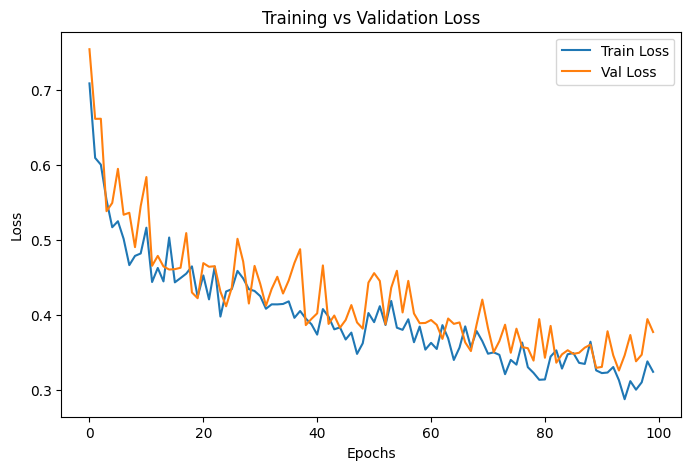

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


### Model Evaluation

In [49]:
import torch
import numpy as np
from tqdm import tqdm

# ----- Metrics -----
def compute_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()
        if union == 0:
            ious.append(np.nan)  # ignore empty classes
        else:
            ious.append(intersection / union)
    return np.array(ious)


# ----- Load best model -----
best_model_path = "./best_unet_model.pth"
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    classes=len(train_dataset.class_colors),
    activation=None
).to(device)

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ Loaded best model from {best_model_path}")

# ----- Predict on test set -----
all_preds, all_gts = [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        masks  = masks.to(device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_gts.append(masks.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()  # [N,H,W]
all_gts   = torch.cat(all_gts, dim=0).numpy()    # [N,H,W]

# ----- Compute mean IoU -----
num_classes = len(train_dataset.class_colors)
ious = []
for pred, gt in zip(all_preds, all_gts):
    ious.append(compute_iou(pred, gt, num_classes))
ious = np.array(ious)

mean_ious = np.nanmean(ious, axis=0)
for cls_idx, miou in enumerate(mean_ious):
    print(f"Class {train_dataset.idx_to_name[cls_idx]}: IoU = {miou:.4f}")
print("Mean IoU:", np.nanmean(mean_ious))


✅ Loaded best model from ./best_unet_model.pth


Evaluating: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Class Water: IoU = 0.8017
Class Land (unpaved area): IoU = 0.7284
Class Road: IoU = 0.3130
Class Building: IoU = 0.2950
Class Vegetation: IoU = 0.3201
Class Unlabeled: IoU = 0.0124
Mean IoU: 0.4117756572125875


### Visualize predictions

In [50]:
def visualize_predictions(dataset, preds, num_samples=4):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    class_colors = dataset.class_colors

    plt.figure(figsize=(12, num_samples * 3))
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        pred_mask = preds[idx]

        if torch.is_tensor(img):
            img = img.permute(1,2,0).numpy()
            img = (img - img.min()) / (img.max() - img.min())

        # Color masks
        gt_color = np.zeros((*mask.shape,3), dtype=np.uint8)
        pred_color = np.zeros((*mask.shape,3), dtype=np.uint8)
        for cls_idx, color in enumerate(class_colors):
            gt_color[mask==cls_idx] = color
            pred_color[pred_mask==cls_idx] = color

        # Plot
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {idx}")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(gt_color)
        plt.axis("off")
        plt.title("Ground Truth")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_color)
        plt.axis("off")
        plt.title("Prediction")

    plt.tight_layout()
    plt.show()

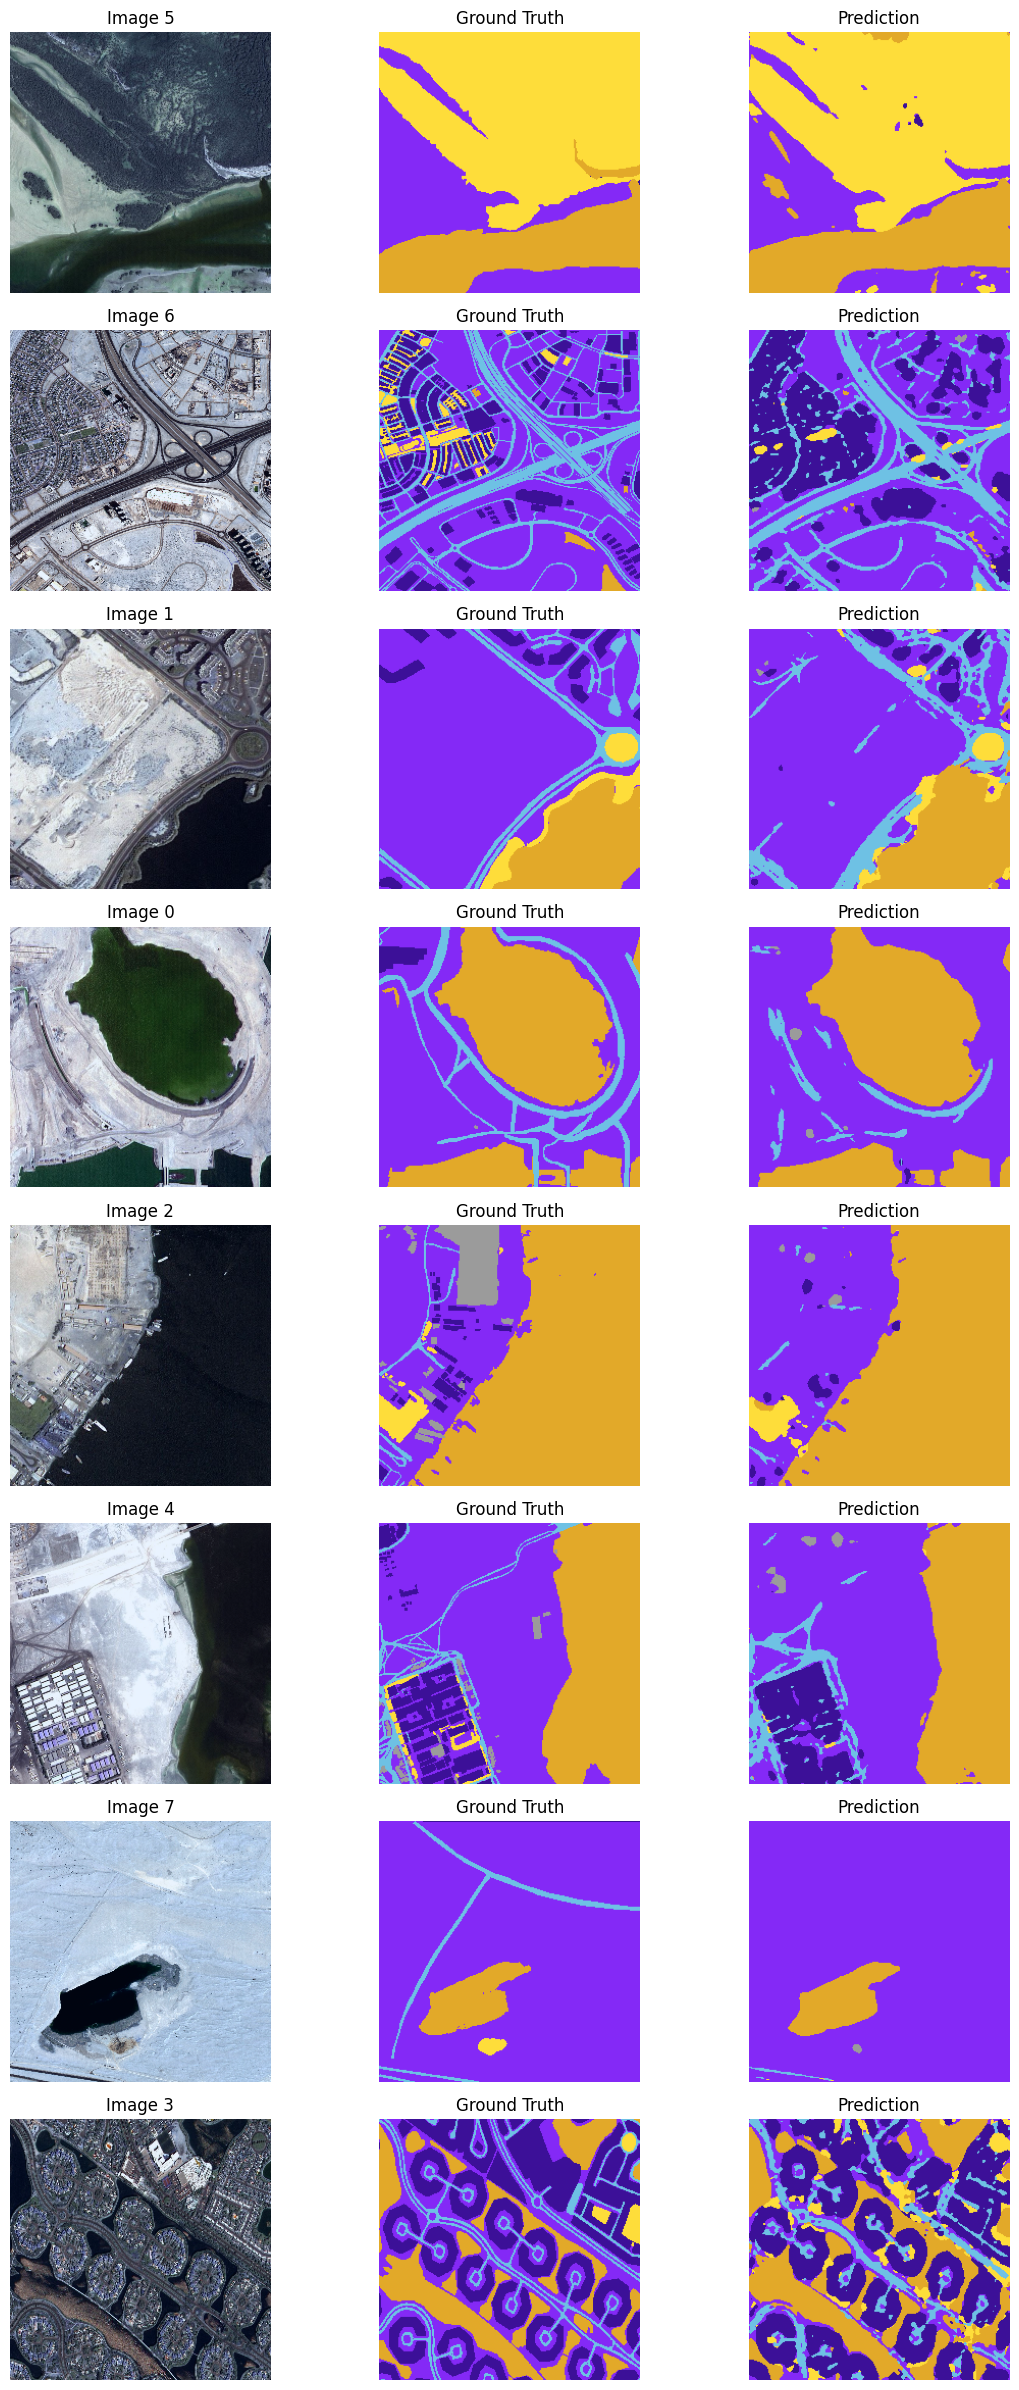

In [51]:
visualize_predictions(test_dataset, all_preds, num_samples=8)